# fish fish facts! 
base model, CNN and transfer learning
<div> <img src="images/230130_logo_2.png" alt="Drawing" style="width: 400px;"/></div> 

# Import images 

In [1]:
# !pip install tensorflow-macos
# !pip install tensorflow-hub
# !pip install tensorflow-datasets

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

import pandas as pd

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [489]:
# Formatting the column display in jupyter labs
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 200)
pd.set_option('display.max_colwidth', None)

In [490]:
print(tf.__version__)

2.11.0


### move pictures to subfolders

In [240]:
# The data contains 193 different families of fish divided into 483 species of fish. 
# Classifiying only on the family level would therefore only double the number of images per class, 
# without assuring a consistent number of images per class

#file_list = pd.read_csv('data/fish_data/list.csv', header=None)
#file_list.columns = ['index_2', 'pre_folder_name', 'controlled_info', 'combined', 'pre_file_name']
#
#file_list_2 = file_list['pre_folder_name'].str.split('\_', expand=True)
#file_list_2.columns = ['family','species','subspecies']
#
#file_list = pd.concat([file_list, file_list_2], axis=0, ignore_index=True)
#
#
#file_list['file_name'] = '/Users/nlory/.keras/datasets/fish_photos/numbered/' + file_list['pre_file_name'].astype(str) + '.png'
#file_list['folder_name'] = '/Users/nlory/.keras/datasets/fish_photos/numbered/' + file_list['pre_folder_name'].astype(str) + '/'
#file_list['file_name_new'] = file_list['folder_name'].astype(str) + file_list['pre_file_name'].astype(str) + '.png'
#
#df = file_list[['file_name','folder_name', 'file_name_new', 'pre_file_name', 'pre_folder_name', 'family','species']].copy()
#df
#file_list_2
#df['family'].nunique()

### import to keras/tensorflow

[https://www.tensorflow.org/tutorials/load_data/images](https://www.tensorflow.org/tutorials/load_data/images)

In [698]:
import pathlib
from pathlib import Path

In [699]:
data_dir = Path('data/fish_data/images/numbered')


In [700]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)


4411


In [701]:
#batch_size = 32
batch_size = 5
img_height = 244
img_width = 244


In [702]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 4411 files belonging to 483 classes.
Using 3529 files for training.


In [703]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 4411 files belonging to 483 classes.
Using 882 files for validation.


In [704]:
class_names = train_ds.class_names
print(class_names)

['A73EGS-P', 'CUNWCB-Y', 'Istiophorus_platypterus', 'P1ROZC-Z', 'PQV7DP-S', 'acanthaluteres_brownii', 'acanthaluteres_spilomelanurus', 'acanthaluteres_vittiger', 'acanthistius_cinctus', 'acanthopagrus_australis', 'acanthopagrus_berda', 'acanthopagrus_latus', 'achoerodus_gouldii', 'achoerodus_viridis', 'acreichthys_tomentosus', 'aesopia_cornuta', 'aethaloperca_rogaa', 'alectis_ciliaris', 'alectis_indica', 'alepes_kleinii', 'aluterus_monoceros', 'aluterus_scriptus', 'amanses_scopas', 'anampses_caeruleopunctatus', 'anampses_elegans', 'anampses_femininus', 'anampses_geographicus', 'anampses_lennardi', 'anampses_melanurus', 'anampses_meleagrides', 'anampses_neoguinaicus', 'anampses_twistii', 'anodontostoma_chacunda', 'anyperodon_leucogrammicus', 'aphareus_furca', 'aphareus_rutilans', 'aprion_virescens', 'argyrops_spinifer', 'aseraggodes_melanostictus', 'atractoscion_aequidens', 'atule_mate', 'auxis_rochei', 'auxis_thazard', 'bathylagichthys_greyae', 'beryx_decadactylus', 'bodianus_anthioide

2023-01-31 11:16:44.873723: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at strided_slice_op.cc:111 : INVALID_ARGUMENT: slice index 5 of dimension 0 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 5 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

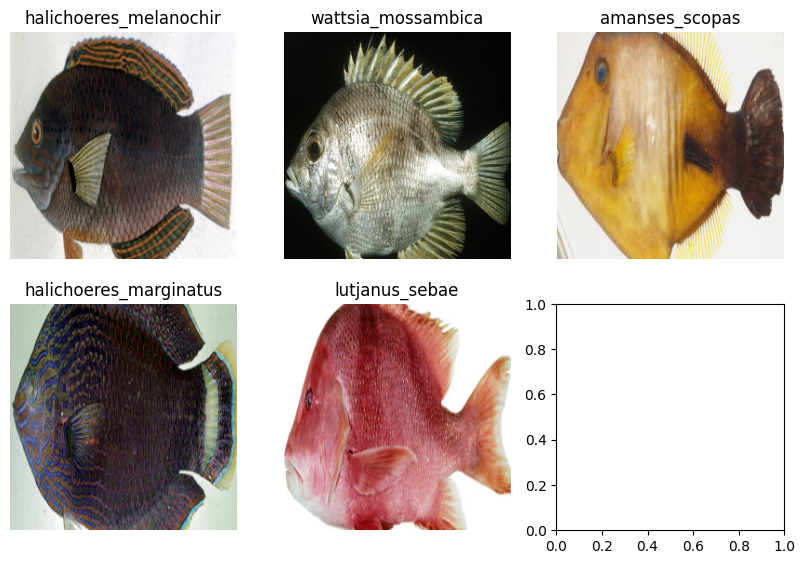

In [705]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [706]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(5, 244, 244, 3)
(5,)


In [707]:
# normalize color values
normalization_layer = tf.keras.layers.Rescaling(1./255)


In [708]:
# optional: apply normailzation to the dataset
#normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
## Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))


### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

* Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
* Dataset.prefetch overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide. [link](https://www.tensorflow.org/guide/data_performance)

In [709]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# First test model

In [649]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [710]:
# original base model
num_classes = 483

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [711]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20,
  callbacks=[tensorboard_callback]
)


Epoch 1/20
706/706 [==============================] - 115s 157ms/step - loss: 6.1581 - accuracy: 0.0037 - val_loss: 6.1093 - val_accuracy: 0.0102
Epoch 2/20
706/706 [==============================] - 114s 162ms/step - loss: 6.0022 - accuracy: 0.0071 - val_loss: 6.1822 - val_accuracy: 0.0113
Epoch 3/20
706/706 [==============================] - 112s 158ms/step - loss: 5.6902 - accuracy: 0.0312 - val_loss: 6.5876 - val_accuracy: 0.0227
Epoch 4/20
706/706 [==============================] - 120s 169ms/step - loss: 5.0393 - accuracy: 0.0938 - val_loss: 7.7310 - val_accuracy: 0.0442
Epoch 5/20
421/706 [================>.............] - ETA: 45s - loss: 4.3050 - accuracy: 0.1720

In [545]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 92442), started 0:42:49 ago. (Use '!kill 92442' to kill it.)

In [546]:
# try to predict with random picture
from PIL import Image
import numpy as np
from skimage import transform
import os

def load(filename):
   np_image = Image.open('data/fish_data/images/numbered/acanthopagrus_berda/42.png')
   np_image = np.array(np_image).astype(int)
   np_image = transform.resize(np_image, (150, 150, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load("42.png")
y_pred = model.predict(image).argmax(axis=1)
print('\nclass', y_pred[0],':', class_names[y_pred[0]])

1/1 [==============================] - 0s 110ms/step

class 78 : caranx_melampygus


In [547]:
def load(filename):
   np_image = Image.open('data/fish_data/images/numbered/acreichthys_tomentosus/69.png')
   np_image = np.array(np_image).astype(int)
   np_image = transform.resize(np_image, (150, 150, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load("69.png")
y_pred = model.predict(image).argmax(axis=1)
print('\nclass', y_pred[0],':', class_names[y_pred[0]])


1/1 [==============================] - 0s 35ms/step

class 78 : caranx_melampygus


### save test-model
[tutorial to save models](https://www.tensorflow.org/tutorials/keras/save_and_load)

In [18]:
# !pip install pyyaml h5py  # Required to save models in HDF5 format

In [20]:
# import os
# import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)


2.11.0


In [21]:
# save the model: 

model.save('models/230125_first_test_model')
# tf.saved_model.save(model, "models/230125_first_test_model_2")

INFO:tensorflow:Assets written to: models/230125_first_test_model/assets


INFO:tensorflow:Assets written to: models/230125_first_test_model/assets


# Converting tf.PrefetchDataset to datatype suitable for vision transformer (keras.sequential) - doesn't work

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])


In [96]:
# tf.keras.layers.RandomContrast, tf.keras.layers.RandomCrop, tf.keras.layers.RandomZoom,

IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])


data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [133]:
num_classes = 483

model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  #resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [136]:
num_classes = 483

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [137]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [138]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=12
)

Epoch 1/12
111/111 [==============================] - 27s 238ms/step - loss: 6.1327 - accuracy: 0.0062 - val_loss: 5.9813 - val_accuracy: 0.0091
Epoch 2/12
111/111 [==============================] - 26s 235ms/step - loss: 5.7629 - accuracy: 0.0201 - val_loss: 5.7326 - val_accuracy: 0.0249
Epoch 3/12
111/111 [==============================] - 25s 225ms/step - loss: 5.1584 - accuracy: 0.0669 - val_loss: 5.3968 - val_accuracy: 0.0850
Epoch 4/12
111/111 [==============================] - 26s 233ms/step - loss: 4.0553 - accuracy: 0.2154 - val_loss: 5.1295 - val_accuracy: 0.1417
Epoch 5/12
111/111 [==============================] - 29s 258ms/step - loss: 2.8631 - accuracy: 0.3908 - val_loss: 5.4840 - val_accuracy: 0.1791
Epoch 6/12
111/111 [==============================] - 26s 236ms/step - loss: 1.9794 - accuracy: 0.5506 - val_loss: 5.7011 - val_accuracy: 0.2120
Epoch 7/12
111/111 [==============================] - 26s 238ms/step - loss: 1.3765 - accuracy: 0.6704 - val_loss: 5.9328 - val_ac

In [56]:
# weird thing i found on stack overflow
def transform(image, label):
    image = tf.image.flip_left_right(image)
    return image, label

#It works well if I apply the transformation directly to the dataset. But it doesn't increase the amount of data:

#ds = ds.map(transform)

#So, I tried to create a second dataset and concatenate both:

ds0 = train_ds.map(transform)
ds = train_ds.concatenate(ds0)


In [62]:
class_names = train_ds.class_names
print(class_names)

AttributeError: 'PrefetchDataset' object has no attribute 'class_names'

In [55]:
#load dataset in to numpy array
sess = tf.compat.v1.Session()
tra=train_ds.batch(1000).make_one_shot_iterator().get_next()
train_A=np.array(sess.run(tra)[0])
print(train_A.shape)
sess.close()

AttributeError: 'BatchDataset' object has no attribute 'make_one_shot_iterator'

In [54]:
print(type(x_train))
print(type(train_ds))

<class 'numpy.ndarray'>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


In [44]:


batch_size = 32

# did not work
#prefetch_dataset_train = train_ds.batch(batch_size)
#prefetch_dataset_val = val_ds.batch(batch_size)

#prefetch_dataset_train = train_ds.as_numpy_iterator()



2023-01-26 12:28:58.508454: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-01-26 12:28:58.508485: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-01-26 12:28:58.508496: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. I

# Tutorial on vision transformer - doesn't work

[transformer tutorial](https://keras.io/examples/vision/image_classification_with_vision_transformer/)

[alternative tutorial that requires different folder structure](https://www.kaggle.com/code/abhinand05/vision-transformer-vit-tutorial-baseline)

In [ ]:
# !pip install -U tensorflow-addons

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


In [ ]:
# example dataset from tutorial
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [ ]:
# Configure the hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [ ]:
data_augmentation = keras.Sequential(
    [
        #layers.Normalization(),
        #layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
# data_augmentation.layers[0].adapt()




In [ ]:
# Implement multilayer perceptron (MLP)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [ ]:
# Implement patch creation as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


[geeksforgeeks page](https://www.geeksforgeeks.org/python-image-classification-using-keras/)

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


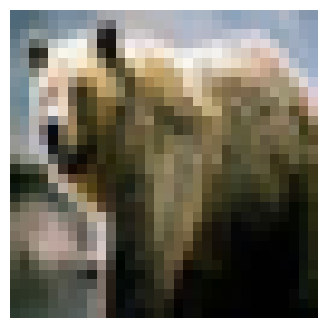

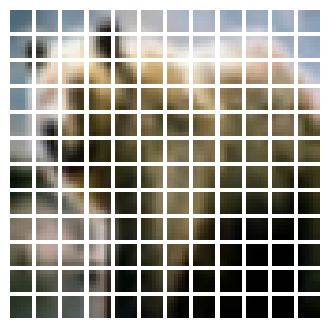

In [ ]:
# Let's display patches for a sample image

import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


In [ ]:
# Implement the patch encoding layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [ ]:
# Build the ViT model
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [93]:
# Compile, train, and evaluate the model
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/model_1/patch_encoder_1/add/BroadcastGradientArgs' defined at (most recent call last):
    File "/Users/nlory/.pyenv/versions/3.9.8/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/nlory/.pyenv/versions/3.9.8/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/nlory/.pyenv/versions/3.9.8/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/Users/nlory/.pyenv/versions/3.9.8/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/Users/nlory/.pyenv/versions/3.9.8/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/td/j171mgyn3cvbndk8r221w_9w0000gn/T/ipykernel_73945/352168860.py", line 42, in <module>
      history = run_experiment(vit_classifier)
    File "/var/folders/td/j171mgyn3cvbndk8r221w_9w0000gn/T/ipykernel_73945/352168860.py", line 24, in run_experiment
      history = model.fit(
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/tensorflow_addons/optimizers/weight_decay_optimizers.py", line 168, in minimize
      return super().minimize(
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 585, in minimize
      grads_and_vars = self._compute_gradients(
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 643, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 519, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model_1/patch_encoder_1/add/BroadcastGradientArgs'
Incompatible shapes: [256,25,64] vs. [144,64]
	 [[{{node gradient_tape/model_1/patch_encoder_1/add/BroadcastGradientArgs}}]] [Op:__inference_train_function_57220]

# tensorflow transfer learning - Xception with weights="imagenet",

[https://www.tensorflow.org/guide/keras/transfer_learning](https://www.tensorflow.org/guide/keras/transfer_learning)

[https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/](https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/)

### load data with 'label_mode='categorical','

In [467]:
import pathlib
from pathlib import Path

data_dir = Path('data/fish_data/images/numbered')
batch_size = 10
img_height = 150
img_width = 150

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#AUTOTUNE = tf.data.AUTOTUNE
#
#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

class_names = train_ds.class_names
print(len(class_names))
print(class_names)

Found 4411 files belonging to 483 classes.
Using 3529 files for training.
Found 4411 files belonging to 483 classes.
Using 882 files for validation.
483
['A73EGS-P', 'CUNWCB-Y', 'Istiophorus_platypterus', 'P1ROZC-Z', 'PQV7DP-S', 'acanthaluteres_brownii', 'acanthaluteres_spilomelanurus', 'acanthaluteres_vittiger', 'acanthistius_cinctus', 'acanthopagrus_australis', 'acanthopagrus_berda', 'acanthopagrus_latus', 'achoerodus_gouldii', 'achoerodus_viridis', 'acreichthys_tomentosus', 'aesopia_cornuta', 'aethaloperca_rogaa', 'alectis_ciliaris', 'alectis_indica', 'alepes_kleinii', 'aluterus_monoceros', 'aluterus_scriptus', 'amanses_scopas', 'anampses_caeruleopunctatus', 'anampses_elegans', 'anampses_femininus', 'anampses_geographicus', 'anampses_lennardi', 'anampses_melanurus', 'anampses_meleagrides', 'anampses_neoguinaicus', 'anampses_twistii', 'anodontostoma_chacunda', 'anyperodon_leucogrammicus', 'aphareus_furca', 'aphareus_rutilans', 'aprion_virescens', 'argyrops_spinifer', 'aseraggodes_mel

### maybe working transfer learning

In [427]:
print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(val_ds)
)
# print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))


Number of training samples: 353
Number of validation samples: 89


In [428]:
len(list(train_ds))

353

In [429]:
# use to one hot encode classes?! tensorflow.keras.utils.to_categorical

In [433]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [434]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)


In [435]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(483)(x)
model = keras.Model(inputs, outputs)

model.summary()


Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_60 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_29 (Sequential)  (None, 150, 150, 3)       0         
                                                                 
 rescaling_27 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_26  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_49 (Dropout)        (None, 2048)              0         
                                                          

In [436]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits=False), #reduction=losses_utils.ReductionV2.AUTO,
    metrics=[keras.metrics.CategoricalAccuracy()],
)

epochs = 1


model.fit(train_ds, epochs=epochs, validation_data=val_ds,callbacks=[tensorboard_callback])


353/353 [==============================] - 97s 260ms/step - loss: 9.8539 - categorical_accuracy: 0.0108 - val_loss: 10.1713 - val_categorical_accuracy: 0.0170


In [437]:
%tensorboard --logdir logs/fit

In [438]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

#epochs = 10
epochs = 5

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds,callbacks=[tensorboard_callback])


Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_60 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_29 (Sequential)  (None, 150, 150, 3)       0         
                                                                 
 rescaling_27 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_26  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_49 (Dropout)        (None, 2048)              0         
                                                          

353/353 [==============================] - 285s 769ms/step - loss: 6.6099 - categorical_accuracy: 0.0145 - val_loss: 6.1949 - val_categorical_accuracy: 0.0113
Epoch 2/5
353/353 [==============================] - 282s 799ms/step - loss: 6.1401 - categorical_accuracy: 0.0184 - val_loss: 6.1737 - val_categorical_accuracy: 0.0159
Epoch 3/5
353/353 [==============================] - 259s 734ms/step - loss: 6.0332 - categorical_accuracy: 0.0289 - val_loss: 6.0885 - val_categorical_accuracy: 0.0295
Epoch 4/5
353/353 [==============================] - 245s 694ms/step - loss: 5.8438 - categorical_accuracy: 0.0485 - val_loss: 5.9698 - val_categorical_accuracy: 0.0408
Epoch 5/5
353/353 [==============================] - 245s 695ms/step - loss: 5.6005 - categorical_accuracy: 0.0703 - val_loss: 5.8289 - val_categorical_accuracy: 0.0567


In [439]:
%tensorboard --logdir logs/fit


Reusing TensorBoard on port 6006 (pid 91052), started 0:24:35 ago. (Use '!kill 91052' to kill it.)

In [326]:
model.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_25 (Sequential)  (None, 150, 150, 3)       0         
                                                                 
 rescaling_23 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_22  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_45 (Dropout)        (None, 2048)              0         
                                                          

ValueError: x and y must have same first dimension, but have shapes (5,) and (10,)

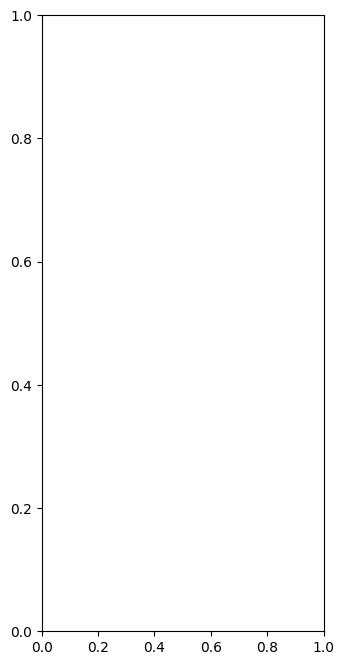

In [601]:
# visualize training

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
   
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [441]:
model.evaluate(val_ds)

89/89 [==============================] - 22s 211ms/step - loss: 5.8289 - categorical_accuracy: 0.0567


[5.828929424285889, 0.056689340621232986]

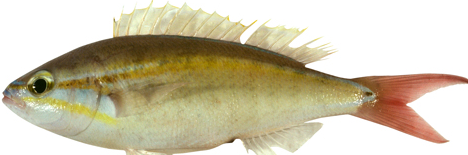

In [347]:
class_1 = list(data_dir.glob('pentapodus_paradiseus/*'))
PIL.Image.open(str(class_1[0]))


In [449]:
!pip install scikit-image

362298.41s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 3.4 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 3.3 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 3.3 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 3.3 MB/s eta 0:00:000:00:01m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.8/214.8 kB 2.7 MB/s eta 0:00:00 MB/s eta 0:00:01


In [461]:
data_dir

PosixPath('data/fish_data/images/numbered')

In [486]:
from PIL import Image
import numpy as np
from skimage import transform
import os

def load(filename):
   np_image = Image.open('data/fish_data/images/numbered/pentapodus_paradiseus/3161.png')
   np_image = np.array(np_image).astype(int)
   np_image = transform.resize(np_image, (150, 150, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load("3161.png")
y_pred = model.predict(image).argmax(axis=1)
print('\nclass', y_pred[0],':', class_names[y_pred[0]])


1/1 [==============================] - 0s 37ms/step

class 230 : hyporhamphus_dussumieri


In [485]:
def load(filename):
   np_image = Image.open('data/fish_data/images/numbered/acanthopagrus_berda/42.png')
   np_image = np.array(np_image).astype(int)
   np_image = transform.resize(np_image, (150, 150, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load("42.png")
y_pred = model.predict(image).argmax(axis=1)
print('\nclass', y_pred[0],':', class_names[y_pred[0]])

def load(filename):
   np_image = Image.open('data/fish_data/images/numbered/acreichthys_tomentosus/69.png')
   np_image = np.array(np_image).astype(int)
   np_image = transform.resize(np_image, (150, 150, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load("69.png")
y_pred = model.predict(image).argmax(axis=1)
print('\nclass', y_pred[0],':', class_names[y_pred[0]])


1/1 [==============================] - 0s 54ms/step

class 230 : hyporhamphus_dussumieri


In [487]:
def load(filename):
   np_image = Image.open('data/fish_data/images/numbered/acreichthys_tomentosus/69.png')
   np_image = np.array(np_image).astype(int)
   np_image = transform.resize(np_image, (150, 150, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load("69.png")
y_pred = model.predict(image).argmax(axis=1)
print('\nclass', y_pred[0],':', class_names[y_pred[0]])


1/1 [==============================] - 0s 43ms/step

class 230 : hyporhamphus_dussumieri


230

In [319]:
# save the model: 

model.save('models/230127_transfer_learning_model')


INFO:tensorflow:Assets written to: models/230127_transfer_learning_model/assets


INFO:tensorflow:Assets written to: models/230127_transfer_learning_model/assets


# Augmentation directly on the data set

[image augmentation](https://keras.io/api/layers/preprocessing_layers/image_augmentation/)

In [425]:
# reload data

import pathlib
from pathlib import Path

data_dir = Path('data/fish_data/images/numbered')
batch_size = 10
img_height = 150
img_width = 150

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

class_names = train_ds.class_names
print(len(class_names))
print(class_names)

Found 4411 files belonging to 483 classes.
Using 3529 files for training.
Found 4411 files belonging to 483 classes.
Using 882 files for validation.


AttributeError: 'PrefetchDataset' object has no attribute 'class_names'

In [549]:
aug_1 = tf.keras.layers.RandomCrop(150, 150, seed=None, **kwargs)
aug_2 = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=None, **kwargs)
aug_3 = tf.keras.layers.RandomTranslation(
    height_factor,
    width_factor,
    fill_mode="reflect",
    interpolation="bilinear",
    seed=None,
    fill_value=0.0,
    **kwargs)
aug_4 = tf.keras.layers.RandomRotation(
    factor,
    fill_mode="reflect",
    interpolation="bilinear",
    seed=None,
    fill_value=0.0,
    **kwargs)
aug_5 = tf.keras.layers.RandomZoom(
    height_factor,
    width_factor=None,
    fill_mode="reflect",
    interpolation="bilinear",
    seed=None,
    fill_value=0.0,
    **kwargs)
aug_6 = tf.keras.layers.RandomHeight(
    factor, interpolation="bilinear", seed=None, **kwargs)
aug_7 = tf.keras.layers.RandomWidth(
    factor, interpolation="bilinear", seed=None, **kwargs)
aug_8 = tf.keras.layers.RandomContrast(factor, seed=None, **kwargs)
aug_9 = tf.keras.layers.RandomBrightness(factor=0.2)

NameError: name 'kwargs' is not defined

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation= tf.keras.Sequential([
  aug_1, aug_2, aug_3, aug_4, aug_5, aug_6, aug_7, aug_8, aug_9
])


In [550]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

In [ ]:
#batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)


In [ ]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)


In [ ]:
print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(val_ds)
)

# Try other base models

[https://keras.io/api/applications/#usage-examples-for-image-classification-models](https://keras.io/api/applications/#usage-examples-for-image-classification-models)

keep in mind that different base models take different image size inputs

ChatGPT recommends these pretrained models:

* VGG16 and VGG19: These models were developed by the Visual Geometry Group at the University of Oxford and have proven to be very effective for image classification tasks.
    
*    ResNet: Developed by Microsoft, ResNet is a deep residual network that has been trained on a large dataset and has achieved state-of-the-art performance on several image classification benchmarks.
* ResNet50

*    Inception: The Inception architecture is a family of CNN models developed by Google that have been successful on image classification and other tasks.

*    DenseNet: DenseNet is a convolutional neural network with densely connected layers. It is computationally efficient, and can improve the performance of image classification tasks.

![cnn_base_models](images/CNN_transfer_model_overview.png)

### rescaling layer - source code

In [ ]:
# rescaling layer source code to get riid of all the warnings

class Rescaling(tf.keras.layers.Layer):
"""Multiply inputs by `scale` and adds `offset`.
For instance:
1. To rescale an input in the `[0, 255]` range
to be in the `[0, 1]` range, you would pass `scale=1./255`.
2. To rescale an input in the `[0, 255]` range to be in the `[-1, 1]` 
range,
you would pass `scale=1./127.5, offset=-1`.
The rescaling is applied both during training and inference.
Input shape:
Arbitrary.
Output shape:
Same as input.
Arguments:
scale: Float, the scale to apply to the inputs.
offset: Float, the offset to apply to the inputs.
name: A string, the name of the layer.
"""

def __init__(self, scale, offset=0., name=None, **kwargs):
  self.scale = scale
  self.offset = offset
  super(Rescaling, self).__init__(name=name, **kwargs)

def call(self, inputs):
  dtype = self._compute_dtype
  scale = tf.cast(self.scale, dtype)
  offset = tf.cast(self.offset, dtype)
  return tf.cast(inputs, dtype) * scale + offset

def compute_output_shape(self, input_shape):
  return input_shape

def get_config(self):
  config = {
      'scale': self.scale,
      'offset': self.offset,
  }
  base_config = super(Rescaling, self).get_config()
  return dict(list(base_config.items()) + list(config.items()))

### import_images(batch_size, img_size, data_dir_str = 'data/fish_data/images/numbered_5_classes')

In [ ]:
def import_images(batch_size, img_size, data_dir_str = 'data/fish_data/images/numbered_5_classes'):
    import pathlib
    from pathlib import Path
    data_dir = Path(data_dir_str)
    img_height = img_size
    img_width = img_size
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
      data_dir,
      label_mode='categorical',
      validation_split=0.2,
      subset="training",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
      data_dir,
      label_mode='categorical',
      validation_split=0.2,
      subset="validation",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
    #AUTOTUNE = tf.data.AUTOTUNE
    #
    #train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    #val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    class_names = train_ds.class_names
    number_classes = len(class_names)
    print('number of classes:', len(class_names))
    #print('class names:\n', class_names)
    # needs to happen after defining class names!
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    return train_ds, val_ds, class_names, batch_size, img_size, number_classes

### data_augmentation - keras.sequential layers

In [594]:
# https://stackoverflow.com/questions/71455053/data-augmentation-layer-in-keras-sequential-model


data_augmentation = tf.keras.Sequential([                                    
  tf.keras.layers.RandomFlip('horizontal',
         input_shape=(img_size, img_size, 3)),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomWidth(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomContrast(0.2)                                  
], name='data_augmentation')


### transfer_model(base_model_input, epochs_1 = 3, epochs_2 = 3)

In [663]:
def transfer_model(base_model_input, epochs_1 = 3, epochs_2 = 3):
    # Freeze the base_model
    base_model_input.trainable = False
    
    # Create new model on top
    inputs = keras.Input(shape=(img_size,img_size, 3))
    x = data_augmentation(inputs)  # Apply random data augmentation
    
    # Pre-trained Xception weights requires that input be scaled
    # from (0, 255) to a range of (-1., +1.), the rescaling layer
    # outputs: `(inputs * scale) + offset`
    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(x)
    
    # The base model contains batchnorm layers. We want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so we make sure that the
    # base_model is running in inference mode here.
    x = base_model_input(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    outputs = keras.layers.Dense(number_classes)(x)
    model = keras.Model(inputs, outputs)
    
    model.summary()
    
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss= keras.losses.CategoricalCrossentropy(from_logits=False), #reduction=losses_utils.ReductionV2.AUTO,
        metrics=[keras.metrics.CategoricalAccuracy()],
    )
    
    epochs = epochs_1
    
    
    model.fit(train_ds, epochs=epochs, validation_data=val_ds,callbacks=[tensorboard_callback])
    
    # Unfreeze the base_model. Note that it keeps running in inference mode
    # since we passed `training=False` when calling it. This means that
    # the batchnorm layers will not update their batch statistics.
    # This prevents the batchnorm layers from undoing all the training
    # we've done so far.
    base_model_input.trainable = True
    model.summary()
    
    model.compile(
        optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.CategoricalAccuracy()],
    )
    
    epochs = epochs_2
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds,callbacks=[tensorboard_callback])
    return model, history

### visualize_training(model,accuracy)

In [688]:
# visualize training function

def visualize_training(model = model, accuracy='categorical_accuracy'):
    acc = history.history[accuracy]
    val_acc_name = 'val_' + accuracy
    val_acc = history.history[val_acc_name]

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)
    
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    return plt.show()


### 6 test images predict_6_test_images()

In [686]:
def load_(filename):
    np_image = Image.open('data/fish_data/images/numbered//'+filename)
    np_image = np.array(np_image).astype(int)
    np_image = transform.resize(np_image, (img_size, img_size, 3))
    np_image = np.expand_dims(np_image, axis=0)
    np_image
    
def predict_6_test_images():
    image = load("alectis_ciliaris/91.png")
    y_pred = model.predict(image).argmax(axis=1)
    print('\np#91 alectis_ciliaris predicted as class', y_pred[0],':', class_names[y_pred[0]])
    image = load("CUNWCB-Y/1325.png")
    y_pred = model.predict(image).argmax(axis=1)
    print('\n#1325 CUNWCB-Y predicted as class', y_pred[0],':', class_names[y_pred[0]])
    image = load("anampses_elegans/164.png")
    y_pred = model.predict(image).argmax(axis=1)
    print('\n#164 anampses_elegans predicted as class', y_pred[0],':', class_names[y_pred[0]])
    image = load("carangoides_caeruleopinnatus/589.png")
    y_pred = model.predict(image).argmax(axis=1)
    print('\n#589 carangoides_caeruleopinnatus predicted as class', y_pred[0],':', class_names[y_pred[0]])
    image = load("acanthopagrus_berda/42.png")
    y_pred = model.predict(image).argmax(axis=1)
    print('\n#42 acanthopagrus_berda predicted as class', y_pred[0],':', class_names[y_pred[0]])
    image = load("acreichthys_tomentosus/69.png")
    y_pred = model.predict(image).argmax(axis=1)
    print('\n#69 acreichthys_tomentosus predicted as class', y_pred[0],':', class_names[y_pred[0]])
    


### VGG16

#### VGG16 needs 244 x 244 pixel img_size

In [692]:
train_ds, val_ds, class_names, batch_size, img_size, number_classes = import_images(2, 244,  'data/fish_data/images/numbered')

Found 4411 files belonging to 483 classes.
Using 3529 files for training.
Found 4411 files belonging to 483 classes.
Using 882 files for validation.
number of classes: 483
class names:
 ['A73EGS-P', 'CUNWCB-Y', 'Istiophorus_platypterus', 'P1ROZC-Z', 'PQV7DP-S', 'acanthaluteres_brownii', 'acanthaluteres_spilomelanurus', 'acanthaluteres_vittiger', 'acanthistius_cinctus', 'acanthopagrus_australis', 'acanthopagrus_berda', 'acanthopagrus_latus', 'achoerodus_gouldii', 'achoerodus_viridis', 'acreichthys_tomentosus', 'aesopia_cornuta', 'aethaloperca_rogaa', 'alectis_ciliaris', 'alectis_indica', 'alepes_kleinii', 'aluterus_monoceros', 'aluterus_scriptus', 'amanses_scopas', 'anampses_caeruleopunctatus', 'anampses_elegans', 'anampses_femininus', 'anampses_geographicus', 'anampses_lennardi', 'anampses_melanurus', 'anampses_meleagrides', 'anampses_neoguinaicus', 'anampses_twistii', 'anodontostoma_chacunda', 'anyperodon_leucogrammicus', 'aphareus_furca', 'aphareus_rutilans', 'aprion_virescens', 'arg

In [693]:
base_model_2 = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(img_size, img_size, 3),
    #input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

In [697]:
model, history = transfer_model(base_model_2, epochs_1 = 1, epochs_2 = 1)


Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_87 (InputLayer)       [(None, 244, 244, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 rescaling_67 (Rescaling)    (None, None, None, 3)     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_41  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_77 (Dropout)        (None, 512)               0  

  82/1765 [>.............................] - ETA: 9:04 - loss: nan - categorical_accuracy: 0.0000e+00

KeyboardInterrupt: 

In [695]:
%tensorboard --logdir logs/fit

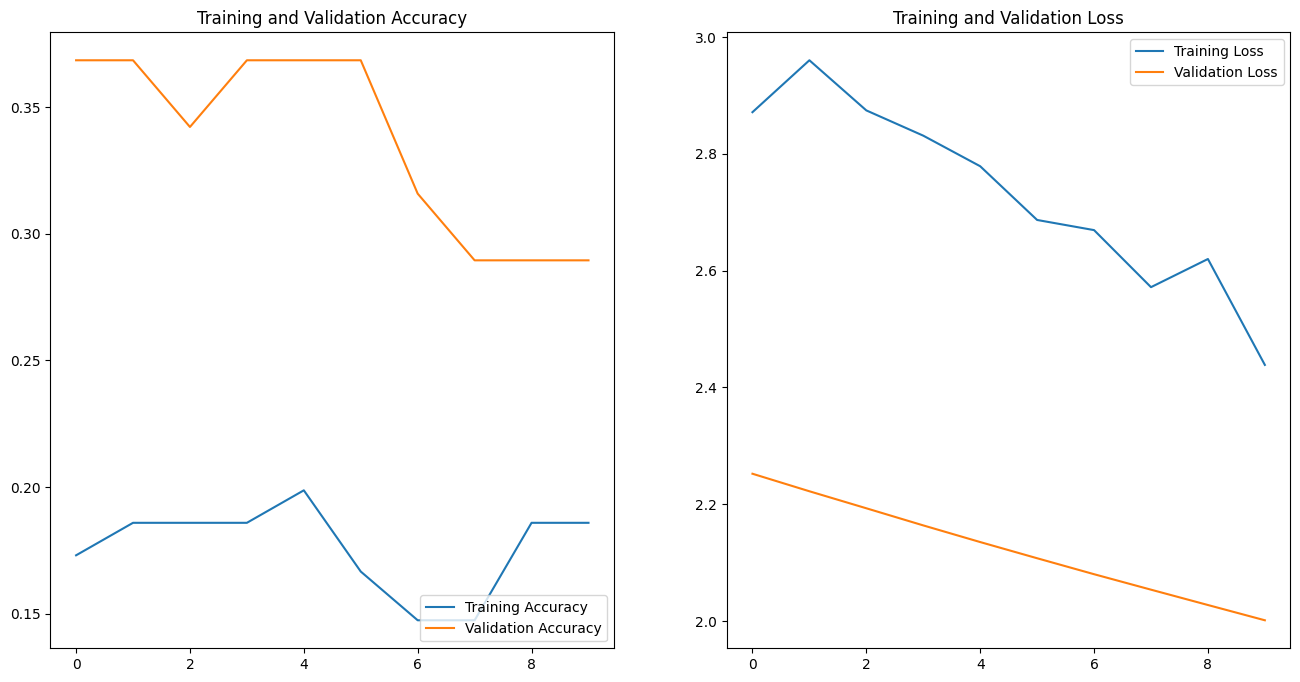

1/1 [==============================] - 0s 151ms/step

p#91 alectis_ciliaris predicted as class 2 : Istiophorus_platypterus
1/1 [==============================] - 0s 142ms/step

#1325 CUNWCB-Y predicted as class 2 : Istiophorus_platypterus
1/1 [==============================] - 0s 138ms/step

#164 anampses_elegans predicted as class 2 : Istiophorus_platypterus
1/1 [==============================] - 0s 161ms/step

#589 carangoides_caeruleopinnatus predicted as class 2 : Istiophorus_platypterus
1/1 [==============================] - 0s 155ms/step

#42 acanthopagrus_berda predicted as class 2 : Istiophorus_platypterus
1/1 [==============================] - 0s 151ms/step

#69 acreichthys_tomentosus predicted as class 2 : Istiophorus_platypterus


In [696]:
# quick check for model
visualize_training()
predict_6_test_images()


In [687]:
model.save('models/230131_VGG16_20e_10e_transfer_model')


1/1 [==============================] - 0s 169ms/step

p#91 alectis_ciliaris predicted as class 2 : Istiophorus_platypterus
1/1 [==============================] - 0s 153ms/step

#1325 CUNWCB-Y predicted as class 2 : Istiophorus_platypterus
1/1 [==============================] - 0s 159ms/step

#164 anampses_elegans predicted as class 2 : Istiophorus_platypterus
1/1 [==============================] - 0s 143ms/step

#589 carangoides_caeruleopinnatus predicted as class 2 : Istiophorus_platypterus
1/1 [==============================] - 0s 130ms/step

#42 acanthopagrus_berda predicted as class 2 : Istiophorus_platypterus
1/1 [==============================] - 0s 122ms/step

#69 acreichthys_tomentosus predicted as class 2 : Istiophorus_platypterus


#### VGG16 without function

In [586]:
import pathlib
from pathlib import Path

data_dir = Path('data/fish_data/images/numbered_5_classes')
batch_size = 1
img_size = 244
img_height = img_size
img_width = img_size

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#AUTOTUNE = tf.data.AUTOTUNE
#
#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

class_names = train_ds.class_names
number_classes = len(class_names)
print(len(class_names))
print(class_names)

# needs to happen after defining class names!

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 194 files belonging to 5 classes.
Using 156 files for training.
Found 194 files belonging to 5 classes.
Using 38 files for validation.
5
['CUNWCB-Y', 'alectis_ciliaris', 'anampses_elegans', 'bodianus_anthioides', 'carangoides_caeruleopinnatus']


In [595]:
#VGG16

base_model_2 = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(img_size, img_size, 3),
    #input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)




In [596]:
# Freeze the base_model
base_model_2.trainable = False

# Create new model on top
inputs = keras.Input(shape=(img_size,img_size, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model_2(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(number_classes)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_72 (InputLayer)       [(None, 244, 244, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 rescaling_43 (Rescaling)    (None, None, None, 3)     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_32  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_57 (Dropout)        (None, 512)               0  

In [597]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits=False), #reduction=losses_utils.ReductionV2.AUTO,
    metrics=[keras.metrics.CategoricalAccuracy()],
)

epochs = 5


model.fit(train_ds, epochs=epochs, validation_data=val_ds,callbacks=[tensorboard_callback])


Epoch 1/5


156/156 [==============================] - 41s 202ms/step - loss: 7.9512 - categorical_accuracy: 0.1859 - val_loss: 5.2286 - val_categorical_accuracy: 0.1316
Epoch 2/5
156/156 [==============================] - 33s 210ms/step - loss: 7.4729 - categorical_accuracy: 0.2628 - val_loss: 6.7866 - val_categorical_accuracy: 0.0789
Epoch 3/5
156/156 [==============================] - 34s 217ms/step - loss: 8.3462 - categorical_accuracy: 0.2372 - val_loss: 11.8765 - val_categorical_accuracy: 0.0789
Epoch 4/5
156/156 [==============================] - 32s 207ms/step - loss: 9.6121 - categorical_accuracy: 0.2244 - val_loss: 11.8765 - val_categorical_accuracy: 0.0789
Epoch 5/5
156/156 [==============================] - 32s 206ms/step - loss: 10.4356 - categorical_accuracy: 0.2051 - val_loss: 12.7248 - val_categorical_accuracy: 0.0789


In [598]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 94178), started 1:07:05 ago. (Use '!kill 94178' to kill it.)

In [591]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

#epochs = 10
epochs = 10

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds,callbacks=[tensorboard_callback])


Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_70 (InputLayer)       [(None, 244, 244, 3)]     0         
                                                                 
 sequential_38 (Sequential)  (None, 244, 244, 3)       0         
                                                                 
 rescaling_42 (Rescaling)    (None, 244, 244, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_31  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_56 (Dropout)        (None, 512)               0         
                                                          

156/156 [==============================] - 39s 193ms/step - loss: 2.7656 - categorical_accuracy: 0.2051 - val_loss: 3.7421 - val_categorical_accuracy: 0.0789
Epoch 2/10
156/156 [==============================] - 34s 220ms/step - loss: 2.6675 - categorical_accuracy: 0.2564 - val_loss: 3.6539 - val_categorical_accuracy: 0.0789
Epoch 3/10
156/156 [==============================] - 31s 201ms/step - loss: 2.6546 - categorical_accuracy: 0.1987 - val_loss: 3.5656 - val_categorical_accuracy: 0.0789
Epoch 4/10
156/156 [==============================] - 31s 201ms/step - loss: 2.5648 - categorical_accuracy: 0.1987 - val_loss: 3.4821 - val_categorical_accuracy: 0.0789
Epoch 5/10
156/156 [==============================] - 31s 199ms/step - loss: 2.5442 - categorical_accuracy: 0.1923 - val_loss: 3.4007 - val_categorical_accuracy: 0.0789
Epoch 6/10
156/156 [==============================] - 32s 203ms/step - loss: 2.3864 - categorical_accuracy: 0.2308 - val_loss: 3.3239 - val_categorical_accuracy: 0.07

In [592]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 94178), started 0:43:42 ago. (Use '!kill 94178' to kill it.)

ValueError: x and y must have same first dimension, but have shapes (5,) and (10,)

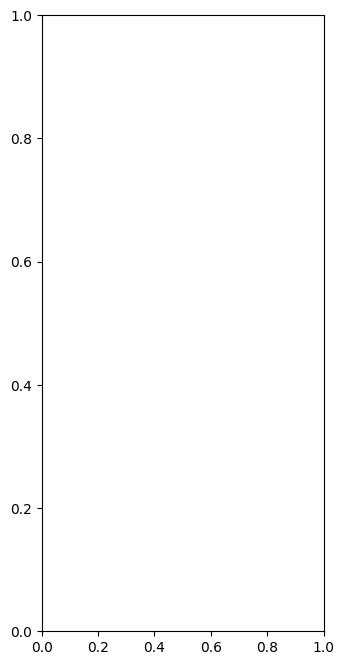

In [600]:
visualize_training()

In [599]:
def load(filename):
   np_image = Image.open('data/fish_data/images/numbered//'+filename)
   np_image = np.array(np_image).astype(int)
   np_image = transform.resize(np_image, (img_size, img_size, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load("alectis_ciliaris/91.png")
y_pred = model.predict(image).argmax(axis=1)
print('\np#91 predicted as class', y_pred[0],':', class_names[y_pred[0]])

image = load("CUNWCB-Y/1325.png")
y_pred = model.predict(image).argmax(axis=1)
print('\n#1325 predicted as class', y_pred[0],':', class_names[y_pred[0]])

image = load("anampses_elegans/164.png")
y_pred = model.predict(image).argmax(axis=1)
print('\n#164 predicted as class', y_pred[0],':', class_names[y_pred[0]])

image = load("carangoides_caeruleopinnatus/589.png")
y_pred = model.predict(image).argmax(axis=1)
print('\n#589 predicted as class', y_pred[0],':', class_names[y_pred[0]])


1/1 [==============================] - 0s 185ms/step

p#91 predicted as class 0 : CUNWCB-Y
1/1 [==============================] - 0s 125ms/step

#1325 predicted as class 0 : CUNWCB-Y
1/1 [==============================] - 0s 128ms/step

#164 predicted as class 0 : CUNWCB-Y
1/1 [==============================] - 0s 128ms/step

#589 predicted as class 0 : CUNWCB-Y


In [ ]:
model.summary()

### VGG19

In [655]:
img_size = 244

In [656]:
import pathlib
from pathlib import Path

data_dir = Path('data/fish_data/images/numbered_5_classes')
batch_size = 1
img_size = 244
img_height = img_size
img_width = img_size

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#AUTOTUNE = tf.data.AUTOTUNE
#
#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

class_names = train_ds.class_names
number_classes = len(class_names)
print(len(class_names))
print(class_names)

# needs to happen after defining class names!

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 194 files belonging to 5 classes.
Using 156 files for training.
Found 194 files belonging to 5 classes.
Using 38 files for validation.
5
['CUNWCB-Y', 'alectis_ciliaris', 'anampses_elegans', 'bodianus_anthioides', 'carangoides_caeruleopinnatus']


In [657]:
# VGG19
base_model_3 = tf.keras.applications.vgg19.VGG19(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)



In [658]:
# Freeze the base_model
base_model_3.trainable = False

# Create new model on top
inputs = keras.Input(shape=(img_size,img_size, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model_2(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(number_classes)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_76 (InputLayer)       [(None, 244, 244, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 rescaling_60 (Rescaling)    (None, None, None, 3)     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_34  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_70 (Dropout)        (None, 512)               0  

In [659]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits=False), #reduction=losses_utils.ReductionV2.AUTO,
    metrics=[keras.metrics.CategoricalAccuracy()],
)

epochs = 5


model.fit(train_ds, epochs=epochs, validation_data=val_ds,callbacks=[tensorboard_callback])


Epoch 1/5


156/156 [==============================] - 43s 204ms/step - loss: 7.8344 - categorical_accuracy: 0.1538 - val_loss: 5.0899 - val_categorical_accuracy: 0.2105
Epoch 2/5
156/156 [==============================] - 32s 206ms/step - loss: 7.3537 - categorical_accuracy: 0.1667 - val_loss: 7.2107 - val_categorical_accuracy: 0.3158
Epoch 3/5
156/156 [==============================] - 30s 195ms/step - loss: 8.7962 - categorical_accuracy: 0.1987 - val_loss: 9.3315 - val_categorical_accuracy: 0.3684
Epoch 4/5
156/156 [==============================] - 32s 208ms/step - loss: 8.9931 - categorical_accuracy: 0.1923 - val_loss: 10.6040 - val_categorical_accuracy: 0.3684
Epoch 5/5
156/156 [==============================] - 33s 213ms/step - loss: 8.7841 - categorical_accuracy: 0.1987 - val_loss: 10.6040 - val_categorical_accuracy: 0.3684


In [660]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

#epochs = 10
epochs = 10

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds,callbacks=[tensorboard_callback])


Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_76 (InputLayer)       [(None, 244, 244, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 rescaling_60 (Rescaling)    (None, None, None, 3)     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_34  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_70 (Dropout)        (None, 512)               0  

156/156 [==============================] - 46s 204ms/step - loss: 2.8712 - categorical_accuracy: 0.1731 - val_loss: 2.2521 - val_categorical_accuracy: 0.3684
Epoch 2/10
156/156 [==============================] - 30s 191ms/step - loss: 2.9601 - categorical_accuracy: 0.1859 - val_loss: 2.2221 - val_categorical_accuracy: 0.3684
Epoch 3/10
156/156 [==============================] - 32s 207ms/step - loss: 2.8742 - categorical_accuracy: 0.1859 - val_loss: 2.1929 - val_categorical_accuracy: 0.3421
Epoch 4/10
156/156 [==============================] - 32s 209ms/step - loss: 2.8310 - categorical_accuracy: 0.1859 - val_loss: 2.1636 - val_categorical_accuracy: 0.3684
Epoch 5/10
156/156 [==============================] - 32s 209ms/step - loss: 2.7786 - categorical_accuracy: 0.1987 - val_loss: 2.1351 - val_categorical_accuracy: 0.3684
Epoch 6/10
156/156 [==============================] - 34s 218ms/step - loss: 2.6866 - categorical_accuracy: 0.1667 - val_loss: 2.1074 - val_categorical_accuracy: 0.36

In [661]:
def load(filename):
   np_image = Image.open('data/fish_data/images/numbered//'+filename)
   np_image = np.array(np_image).astype(int)
   np_image = transform.resize(np_image, (img_size, img_size, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load("alectis_ciliaris/91.png")
y_pred = model.predict(image).argmax(axis=1)
print('\np#91 predicted as class', y_pred[0],':', class_names[y_pred[0]])

image = load("CUNWCB-Y/1325.png")
y_pred = model.predict(image).argmax(axis=1)
print('\n#1325 predicted as class', y_pred[0],':', class_names[y_pred[0]])

image = load("anampses_elegans/164.png")
y_pred = model.predict(image).argmax(axis=1)
print('\n#164 predicted as class', y_pred[0],':', class_names[y_pred[0]])

image = load("carangoides_caeruleopinnatus/589.png")
y_pred = model.predict(image).argmax(axis=1)
print('\n#589 predicted as class', y_pred[0],':', class_names[y_pred[0]])

1/1 [==============================] - 0s 208ms/step

p#91 predicted as class 2 : anampses_elegans
1/1 [==============================] - 0s 125ms/step

#1325 predicted as class 2 : anampses_elegans
1/1 [==============================] - 0s 129ms/step

#164 predicted as class 2 : anampses_elegans
1/1 [==============================] - 0s 129ms/step

#589 predicted as class 2 : anampses_elegans


### ResNet50

In [333]:
# ResNet50

base_model_4 = ResNet50(weights='imagenet', 
                        input_shape=(150, 150, 3),
                        include_top=False)

### ResNet152

In [ ]:
train_ds, val_ds, class_names, batch_size, img_size, number_classes = import_images(2, 244,  'data/fish_data/images/numbered')

In [369]:
# ResNet152V2
base_model_4_2 = tf.keras.applications.resnet_v2.ResNet152V2(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)


In [ ]:
model, history = transfer_model(base_model_4_2, epochs_1 = 1, epochs_2 = 1)

In [ ]:
visualize_training()

### InceptionV3

In [ ]:
train_ds, val_ds, class_names, batch_size, img_size, number_classes = import_images(2, 244,  'data/fish_data/images/numbered')

In [334]:
base_model_5 = InceptionV3(weights='imagenet', 
                        input_shape=(150, 150, 3),
                        include_top=False)

In [ ]:
model, history = transfer_model(base_model_5, epochs_1 = 1, epochs_2 = 1)

In [ ]:
visualize_training()

### DenseNet201

In [ ]:
train_ds, val_ds, class_names, batch_size, img_size, number_classes = import_images(2, 244,  'data/fish_data/images/numbered')

In [370]:
# DenseNet201

base_model_6 = tf.keras.applications.densenet.DenseNet201(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)




In [ ]:
model, history = transfer_model(base_model_5, epochs_1 = 1, epochs_2 = 1)

In [ ]:
visualize_training()